In [62]:
from util import *
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectPercentile, f_classif
from sklearn.model_selection import cross_validate, LeaveOneGroupOut, cross_val_score
from sklearn.svm import LinearSVC, SVC
from sklearn.dummy import DummyClassifier
import os
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stat
from sklearn import svm, tree, neural_network
from sklearn.model_selection import StratifiedKFold, cross_val_predict
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.multiclass import OneVsRestClassifier

In [2]:
atlas = datasets.fetch_atlas_juelich("maxprob-thr25-2mm")

In [3]:
masks = {"premotor":"GM Premotor cortex BA6", 
         "motor": "GM Primary motor cortex BA4a",
         "v1": "GM Visual cortex V1 BA17",
         "sup_parietal": "GM Superior parietal lobule 7P",
         "inf_parietal": "GM Inferior parietal lobule PF",
         "v5": "GM Visual cortex V5"
        }


In [4]:
subject_list = ['01', '02', '03', '04', '05', '06', '07', '08', '09', '11', '12', '13', '14', '15', '16', '17', '18', '19']

In [22]:
svm_predictions = []
dec_tree_predictions = []
knn_predictions = []
for subject_id in subject_list:
    for mask in masks.keys():

        for run in range(1, 11):
            X = []
            run_no = str(run).zfill(2)
            beta_maps_dir = f'analyses_results/sub-{subject_id}/beta_maps/trial_level/run-{run_no}/'
            run_beta_maps = os.listdir(f'analyses_results/sub-{subject_id}/beta_maps/trial_level/run-{run_no}/')

            z_maps = {}

            for i in run_beta_maps:
                z_maps[i[5:-7]] = image.load_img(os.path.join(beta_maps_dir, i))

            #Sorted by first number
            all_images = image.concat_imgs((z_maps['153'], z_maps['207'], z_maps['45'], z_maps['99']))
            #mean_image = image.mean_img(all_images)
            #mean_centered = image.math_img("np.subtract(all_images, mean_image[:, :, :, None])", all_images = all_images, mean_image = mean_image)
            #mean_centered = all_images

            #for i, key in enumerate(np.sort(list(z_maps.keys()))):

                #z_maps[key] = image.index_img(mean_centered, slice(i*10,i*10+10))

            mask_image = image.new_img_like(atlas.maps, image.get_data(atlas.maps) == np.where(np.array(atlas.labels) == masks[mask])[0][0])
            resampled_mask = image.resample_to_img(mask_image, all_images, interpolation='nearest')

            fmri_masked = masking.apply_mask(all_images, mask_img=resampled_mask)
            #X.append(fmri_masked)
            #X_test.append(fmri_masked[1::2])

            #X = np.concatenate(X)
            X = fmri_masked
            y = np.tile(np.repeat(['153', '207', '45', '99'], 10), 1)
            #svm_predictions.append(cross_val_predict(OneVsRestClassifier(svm.SVC(probability = True)), X, y, cv=10, method='predict_proba'))
            dec_tree_predictions.append(cross_val_predict(tree.DecisionTreeClassifier(max_depth=4), X, y, cv=10, method='predict_proba'))
            knn_predictions.append(cross_val_predict(KNeighborsClassifier(), X, y, cv=10, method='predict_proba'))

        print("Mask done: ", mask)
    print('Subject done:', subject_id)



Mask done:  premotor
Mask done:  motor
Mask done:  v1
Mask done:  sup_parietal
Mask done:  inf_parietal
Mask done:  v5
Subject done: 01
Mask done:  premotor
Mask done:  motor
Mask done:  v1
Mask done:  sup_parietal
Mask done:  inf_parietal
Mask done:  v5
Subject done: 02
Mask done:  premotor
Mask done:  motor
Mask done:  v1
Mask done:  sup_parietal
Mask done:  inf_parietal
Mask done:  v5
Subject done: 03
Mask done:  premotor
Mask done:  motor
Mask done:  v1
Mask done:  sup_parietal
Mask done:  inf_parietal
Mask done:  v5
Subject done: 04
Mask done:  premotor
Mask done:  motor
Mask done:  v1
Mask done:  sup_parietal
Mask done:  inf_parietal
Mask done:  v5
Subject done: 05
Mask done:  premotor
Mask done:  motor
Mask done:  v1
Mask done:  sup_parietal
Mask done:  inf_parietal
Mask done:  v5
Subject done: 06
Mask done:  premotor
Mask done:  motor
Mask done:  v1
Mask done:  sup_parietal
Mask done:  inf_parietal
Mask done:  v5
Subject done: 07
Mask done:  premotor
Mask done:  motor
Mask done

In [27]:
knn_predictions = np.concatenate(knn_predictions)


In [31]:
knn_predictions = knn_predictions.reshape(43200, 4)

In [28]:
dec_tree_predictions = np.concatenate(dec_tree_predictions)


In [30]:
dec_tree_predictions.shape

(43200, 4)

In [32]:
within_knn_predictions_df = pd.DataFrame({'153_prob': knn_predictions[:, 0], 
                               '207_prob': knn_predictions[:, 1],
                               '45_prob': knn_predictions[:, 2],
                               '99_prob': knn_predictions[:, 3],
                               'ROIs': np.tile(np.repeat(list(masks.keys()), 10*40), len(subject_list)),
                               'run': np.tile(np.tile(np.repeat(np.arange(1, 11), 40), len(masks.keys())), len(subject_list)), 
                               'dir_x_rest': np.tile(np.tile(np.repeat([153, 207, 45, 99], 10), 10* len(masks.keys())), len(subject_list)),
                               'block_type': np.tile(np.tile(np.repeat(['Straight', 'Rotate'], 40), 5 * len(masks.keys())), len(subject_list)),
                               'Subject_id': np.repeat(subject_list, 40*10*len(masks.keys()))
                              })

In [36]:
within_dec_tree_predictions_df = pd.DataFrame({'153_prob': dec_tree_predictions[:, 0], 
                               '207_prob': dec_tree_predictions[:, 1],
                               '45_prob': dec_tree_predictions[:, 2],
                               '99_prob': dec_tree_predictions[:, 3],
                               'ROIs': np.tile(np.repeat(list(masks.keys()), 10*40), len(subject_list)),
                               'run': np.tile(np.tile(np.repeat(np.arange(1, 11), 40), len(masks.keys())), len(subject_list)), 
                               'dir_x_rest': np.tile(np.tile(np.repeat([153, 207, 45, 99], 10), 10* len(masks.keys())), len(subject_list)),
                               'block_type': np.tile(np.tile(np.repeat(['Straight', 'Rotate'], 40), 5 * len(masks.keys())), len(subject_list)),
                               'Subject_id': np.repeat(subject_list, 40*10*len(masks.keys()))
                              })

In [8]:
predictions = np.concatenate(predictions)


In [9]:
within_predictions_df = pd.DataFrame({'153_prob': predictions[:, 0], 
                               '207_prob': predictions[:, 1],
                               '45_prob': predictions[:, 2],
                               '99_prob': predictions[:, 3],
                               'ROIs': np.tile(np.repeat(list(masks.keys()), 10*40), len(subject_list)),
                               'run': np.tile(np.tile(np.repeat(np.arange(1, 11), 40), len(masks.keys())), len(subject_list)), 
                               'dir_x_rest': np.tile(np.tile(np.repeat([153, 207, 45, 99], 10), 10* len(masks.keys())), len(subject_list)),
                               'block_type': np.tile(np.tile(np.repeat(['Straight', 'Rotate'], 40), 5 * len(masks.keys())), len(subject_list)),
                               'Subject_id': np.repeat(subject_list, 40*10*len(masks.keys()))
                              })

In [11]:
within_predictions_df_melt = within_predictions_df.melt(id_vars=['Subject_id', 'dir_x_rest', 'ROIs', 'run', 'block_type'], var_name='dirs', value_name='probs')


In [12]:
within_predictions_df.to_csv('all_way_within_pred.csv')

In [13]:
within_predictions_df = pd.read_csv('all_way_within_pred.csv').drop('Unnamed: 0', axis = 1)
within_predictions_df_melt = within_predictions_df.melt(id_vars=['Subject_id', 'dir_x_rest', 'ROIs', 'run', 'block_type'], var_name='dirs', value_name='probs')


In [34]:
within_knn_predictions_df_melt = within_knn_predictions_df.melt(id_vars=['Subject_id', 'dir_x_rest', 'ROIs', 'run', 'block_type'], var_name='dirs', value_name='probs')


In [37]:
within_dec_tree_predictions_df_melt = within_dec_tree_predictions_df.melt(id_vars=['Subject_id', 'dir_x_rest', 'ROIs', 'run', 'block_type'], var_name='dirs', value_name='probs')


In [40]:
within_knn_predictions_df.to_csv('all_way_knn_within_pred.csv')

In [41]:
within_dec_tree_predictions_df.to_csv('all_way_dec_tree_within_pred.csv')

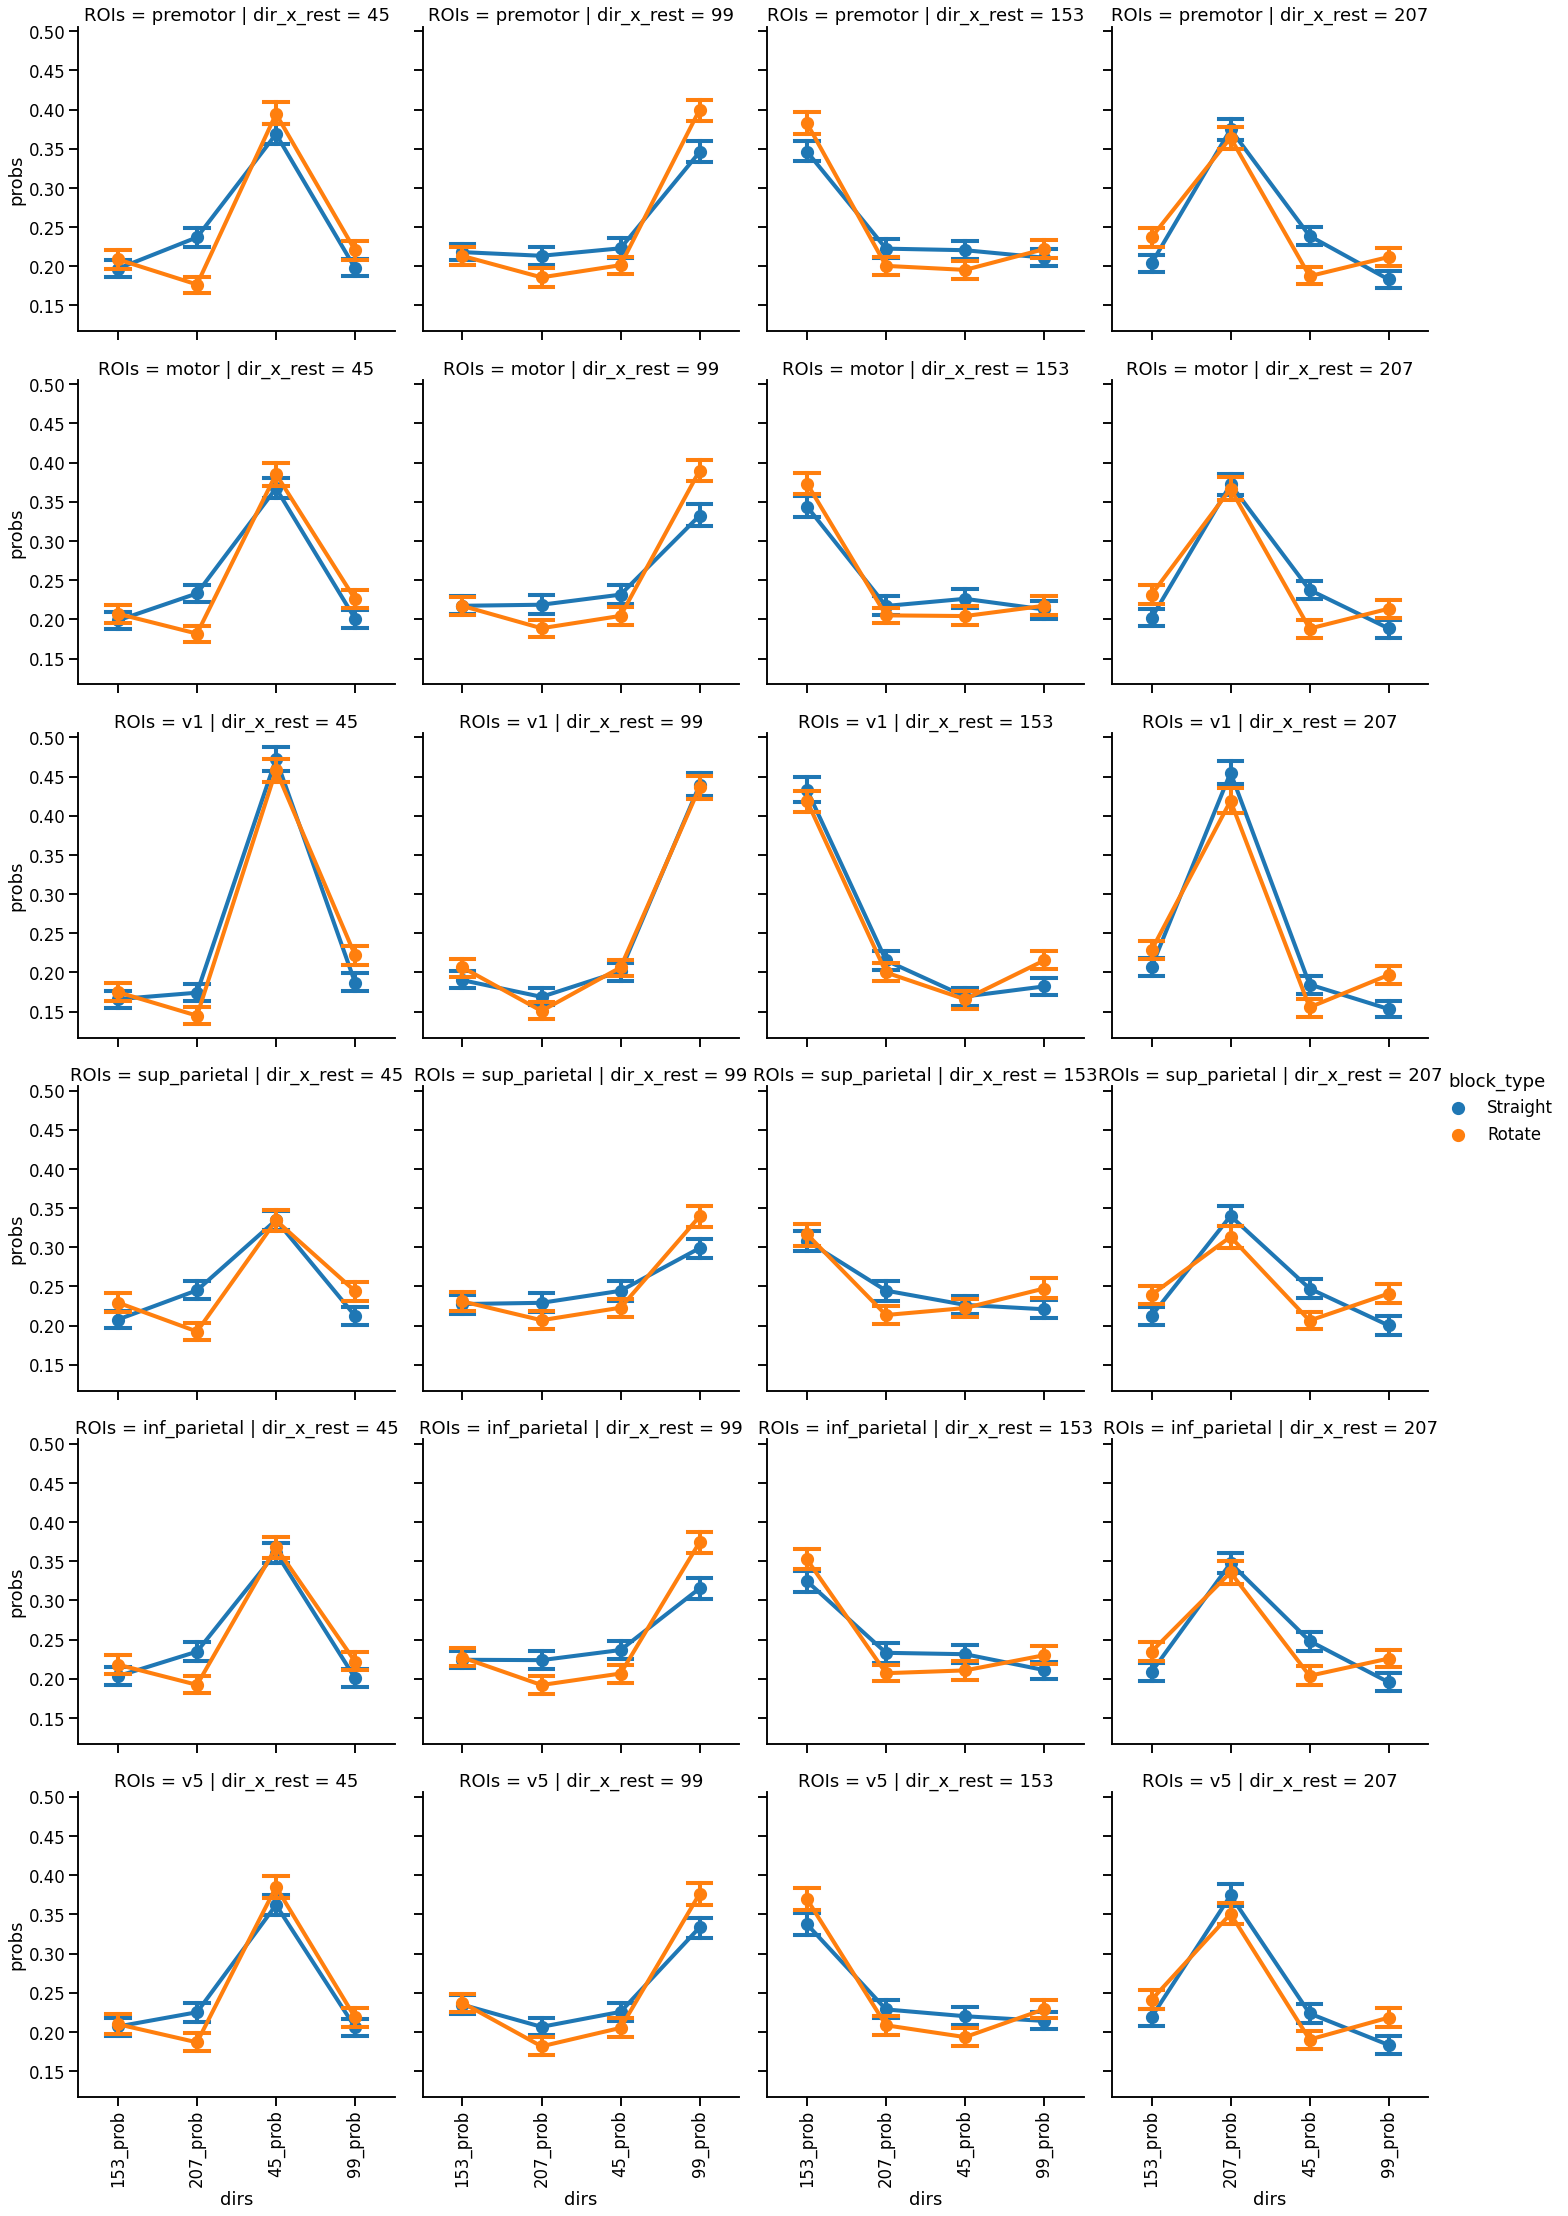

In [45]:
sns.set_context('talk')
ax = sns.catplot(x = 'dirs', y = 'probs', col = 'dir_x_rest', 
            hue = 'block_type', row = 'ROIs', 
            data = within_knn_predictions_df_melt, kind = 'point', capsize = 0.3)
ax.set_axis_labels().set_xticklabels(rotation = 90)


In [63]:
svm_predictions = []
knn_predictions = []
dec_tree_predictions = []
clfnn_predictions = []
for subject_id in subject_list:
    for mask in masks.keys():
        X = []
        X_test = []
        for run in range(1, 11):
            #X = []
            run_no = str(run).zfill(2)
            beta_maps_dir = f'analyses_results/sub-{subject_id}/beta_maps/trial_level/run-{run_no}/'
            run_beta_maps = os.listdir(f'analyses_results/sub-{subject_id}/beta_maps/trial_level/run-{run_no}/')

            z_maps = {}

            for i in run_beta_maps:
                z_maps[i[5:-7]] = image.load_img(os.path.join(beta_maps_dir, i))

            #Sorted by first number
            all_images = image.concat_imgs((z_maps['153'], z_maps['207'], z_maps['45'], z_maps['99']))
            #mean_image = image.mean_img(all_images)
            #mean_centered = image.math_img("np.subtract(all_images, mean_image[:, :, :, None])", all_images = all_images, mean_image = mean_image)
            #mean_centered = all_images

            #for i, key in enumerate(np.sort(list(z_maps.keys()))):

                #z_maps[key] = image.index_img(mean_centered, slice(i*10,i*10+10))

            mask_image = image.new_img_like(atlas.maps, image.get_data(atlas.maps) == np.where(np.array(atlas.labels) == masks[mask])[0][0])
            resampled_mask = image.resample_to_img(mask_image, all_images, interpolation='nearest')

            fmri_masked = masking.apply_mask(all_images, mask_img=resampled_mask)
            #X.append(fmri_masked)
            #X_test.append(fmri_masked[1::2])

            #X = np.concatenate(X)
            if run%2 != 0:
                X.append(fmri_masked)
                #y = np.repeat(['153', '207', '45', '99'], 10)
                #clf = OneVsRestClassifier(svm.SVC(probability = True))
                #clf.fit(X, y)
            else:
                X_test.append(fmri_masked)
                #y_test = np.repeat(['153', '207', '45', '99'], 10)
                
                #predictions.append(clf.predict_proba(X_test))
        X = np.concatenate(X)
        X_test = np.concatenate(X_test)
        y = np.tile(np.repeat(['153', '207', '45', '99'], 10), 5)
        y_test = np.tile(np.repeat(['153', '207', '45', '99'], 10), 5)
            
        #clf = svm.SVC(probability = True)
        #clf.fit(X, y)
        #svm_predictions.append(clf.predict_proba(X_test))
        
        #clfk = KNeighborsClassifier()
        #clfk.fit(X, y)
        #knn_predictions.append(clfk.predict_proba(X_test))
        
        #clft = tree.DecisionTreeClassifier()
        #clft.fit(X, y)
        #dec_tree_predictions.append(clft.predict_proba(X_test))
        
        clfnn = neural_network.MLPClassifier()
        clfnn.fit(X, y)
        clfnn_predictions.append(clfnn.predict_proba(X_test))
        
        print("Mask done: ", mask)
    print('Subject done:', subject_id)



Mask done:  premotor
Mask done:  motor
Mask done:  v1
Mask done:  sup_parietal
Mask done:  inf_parietal


/home/vm01/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Mask done:  v5
Subject done: 01
Mask done:  premotor
Mask done:  motor
Mask done:  v1
Mask done:  sup_parietal
Mask done:  inf_parietal
Mask done:  v5
Subject done: 02
Mask done:  premotor
Mask done:  motor
Mask done:  v1
Mask done:  sup_parietal
Mask done:  inf_parietal
Mask done:  v5
Subject done: 03
Mask done:  premotor
Mask done:  motor
Mask done:  v1
Mask done:  sup_parietal
Mask done:  inf_parietal


/home/vm01/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Mask done:  v5
Subject done: 04
Mask done:  premotor
Mask done:  motor
Mask done:  v1
Mask done:  sup_parietal
Mask done:  inf_parietal


/home/vm01/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Mask done:  v5
Subject done: 05
Mask done:  premotor
Mask done:  motor
Mask done:  v1
Mask done:  sup_parietal
Mask done:  inf_parietal


/home/vm01/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Mask done:  v5
Subject done: 06
Mask done:  premotor
Mask done:  motor
Mask done:  v1
Mask done:  sup_parietal
Mask done:  inf_parietal


/home/vm01/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Mask done:  v5
Subject done: 07
Mask done:  premotor
Mask done:  motor
Mask done:  v1
Mask done:  sup_parietal
Mask done:  inf_parietal


/home/vm01/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Mask done:  v5
Subject done: 08
Mask done:  premotor
Mask done:  motor
Mask done:  v1
Mask done:  sup_parietal
Mask done:  inf_parietal


/home/vm01/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Mask done:  v5
Subject done: 09
Mask done:  premotor
Mask done:  motor
Mask done:  v1
Mask done:  sup_parietal
Mask done:  inf_parietal


/home/vm01/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Mask done:  v5
Subject done: 11
Mask done:  premotor
Mask done:  motor
Mask done:  v1
Mask done:  sup_parietal
Mask done:  inf_parietal
Mask done:  v5
Subject done: 12
Mask done:  premotor
Mask done:  motor
Mask done:  v1
Mask done:  sup_parietal
Mask done:  inf_parietal
Mask done:  v5
Subject done: 13
Mask done:  premotor
Mask done:  motor
Mask done:  v1
Mask done:  sup_parietal
Mask done:  inf_parietal
Mask done:  v5
Subject done: 14
Mask done:  premotor
Mask done:  motor
Mask done:  v1
Mask done:  sup_parietal
Mask done:  inf_parietal
Mask done:  v5
Subject done: 15
Mask done:  premotor
Mask done:  motor
Mask done:  v1
Mask done:  sup_parietal
Mask done:  inf_parietal


/home/vm01/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Mask done:  v5
Subject done: 16
Mask done:  premotor
Mask done:  motor
Mask done:  v1
Mask done:  sup_parietal
Mask done:  inf_parietal
Mask done:  v5
Subject done: 17
Mask done:  premotor
Mask done:  motor
Mask done:  v1
Mask done:  sup_parietal
Mask done:  inf_parietal
Mask done:  v5
Subject done: 18
Mask done:  premotor
Mask done:  motor
Mask done:  v1
Mask done:  sup_parietal
Mask done:  inf_parietal
Mask done:  v5
Subject done: 19


/home/vm01/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


In [47]:
svm_predictions = np.concatenate(svm_predictions)
knn_predictions = np.concatenate(knn_predictions)
dec_tree_predictions = np.concatenate(dec_tree_predictions)
#Temp


In [66]:
clfnn_predictions = np.concatenate(clfnn_predictions)

In [48]:
between_svm_predictions_df = pd.DataFrame({'153_prob': svm_predictions[:, 0], 
                               '207_prob': svm_predictions[:, 1],
                               '45_prob': svm_predictions[:, 2],
                               '99_prob': svm_predictions[:, 3],
                               'ROIs': np.tile(np.repeat(list(masks.keys()), 5*40), len(subject_list)),
                               'run_pairs': np.tile(np.tile(np.repeat(np.arange(1, 6), 40), len(masks.keys())), len(subject_list)), 
                               'rotate_dir': np.tile(np.tile(np.repeat([153, 207, 45, 99], 10), 5* len(masks.keys())), len(subject_list)),
                               #'block_type': np.tile(np.tile(np.repeat(['Straight', 'Rotate'], 40), 5 * len(masks.keys())), len(subject_list)),
                               'Subject_id': np.repeat(subject_list, 40*5*len(masks.keys())),
                              'dir_x_rest': np.tile(np.tile(np.repeat([153, 207, 45, 99], 10), 5* len(masks.keys())), len(subject_list)),

                              })

In [49]:
between_knn_predictions_df = pd.DataFrame({'153_prob': knn_predictions[:, 0], 
                               '207_prob': knn_predictions[:, 1],
                               '45_prob': knn_predictions[:, 2],
                               '99_prob': knn_predictions[:, 3],
                               'ROIs': np.tile(np.repeat(list(masks.keys()), 5*40), len(subject_list)),
                               'run_pairs': np.tile(np.tile(np.repeat(np.arange(1, 6), 40), len(masks.keys())), len(subject_list)), 
                               'rotate_dir': np.tile(np.tile(np.repeat([153, 207, 45, 99], 10), 5* len(masks.keys())), len(subject_list)),
                               #'block_type': np.tile(np.tile(np.repeat(['Straight', 'Rotate'], 40), 5 * len(masks.keys())), len(subject_list)),
                               'Subject_id': np.repeat(subject_list, 40*5*len(masks.keys())),
                              'dir_x_rest': np.tile(np.tile(np.repeat([153, 207, 45, 99], 10), 5* len(masks.keys())), len(subject_list)),

                              })

In [50]:
between_dec_tree_predictions_df = pd.DataFrame({'153_prob': dec_tree_predictions[:, 0], 
                               '207_prob': dec_tree_predictions[:, 1],
                               '45_prob': dec_tree_predictions[:, 2],
                               '99_prob': dec_tree_predictions[:, 3],
                               'ROIs': np.tile(np.repeat(list(masks.keys()), 5*40), len(subject_list)),
                               'run_pairs': np.tile(np.tile(np.repeat(np.arange(1, 6), 40), len(masks.keys())), len(subject_list)), 
                               'rotate_dir': np.tile(np.tile(np.repeat([153, 207, 45, 99], 10), 5* len(masks.keys())), len(subject_list)),
                               #'block_type': np.tile(np.tile(np.repeat(['Straight', 'Rotate'], 40), 5 * len(masks.keys())), len(subject_list)),
                               'Subject_id': np.repeat(subject_list, 40*5*len(masks.keys())),
                              'dir_x_rest': np.tile(np.tile(np.repeat([153, 207, 45, 99], 10), 5* len(masks.keys())), len(subject_list)),

                              })

In [67]:
between_clfnn_predictions_df = pd.DataFrame({'153_prob': clfnn_predictions[:, 0], 
                               '207_prob': clfnn_predictions[:, 1],
                               '45_prob': clfnn_predictions[:, 2],
                               '99_prob': clfnn_predictions[:, 3],
                               'ROIs': np.tile(np.repeat(list(masks.keys()), 5*40), len(subject_list)),
                               'run_pairs': np.tile(np.tile(np.repeat(np.arange(1, 6), 40), len(masks.keys())), len(subject_list)), 
                               'rotate_dir': np.tile(np.tile(np.repeat([153, 207, 45, 99], 10), 5* len(masks.keys())), len(subject_list)),
                               #'block_type': np.tile(np.tile(np.repeat(['Straight', 'Rotate'], 40), 5 * len(masks.keys())), len(subject_list)),
                               'Subject_id': np.repeat(subject_list, 40*5*len(masks.keys())),
                              'dir_x_rest': np.tile(np.tile(np.repeat([153, 207, 45, 99], 10), 5* len(masks.keys())), len(subject_list)),

                              })

In [68]:
between_svm_predictions_df_melt = between_svm_predictions_df.melt(id_vars=['dir_x_rest', 'Subject_id', 'rotate_dir', 'ROIs', 'run_pairs'], var_name='dirs', value_name='probs')
between_knn_predictions_df_melt = between_knn_predictions_df.melt(id_vars=['dir_x_rest', 'Subject_id', 'rotate_dir', 'ROIs', 'run_pairs'], var_name='dirs', value_name='probs')
between_dec_tree_predictions_df_melt = between_dec_tree_predictions_df.melt(id_vars=['dir_x_rest', 'Subject_id', 'rotate_dir', 'ROIs', 'run_pairs'], var_name='dirs', value_name='probs')
between_clfnn_predictions_df_melt = between_clfnn_predictions_df.melt(id_vars=['dir_x_rest', 'Subject_id', 'rotate_dir', 'ROIs', 'run_pairs'], var_name='dirs', value_name='probs')


In [69]:
between_svm_predictions_df.to_csv('all_way_svm_between_pred.csv')
between_knn_predictions_df.to_csv('all_way_knn_between_pred.csv')
between_dec_tree_predictions_df.to_csv('all_way_dec_tree_between_pred.csv')
between_clfnn_predictions_df.to_csv('all_way_dec_tree_between_pred.csv')


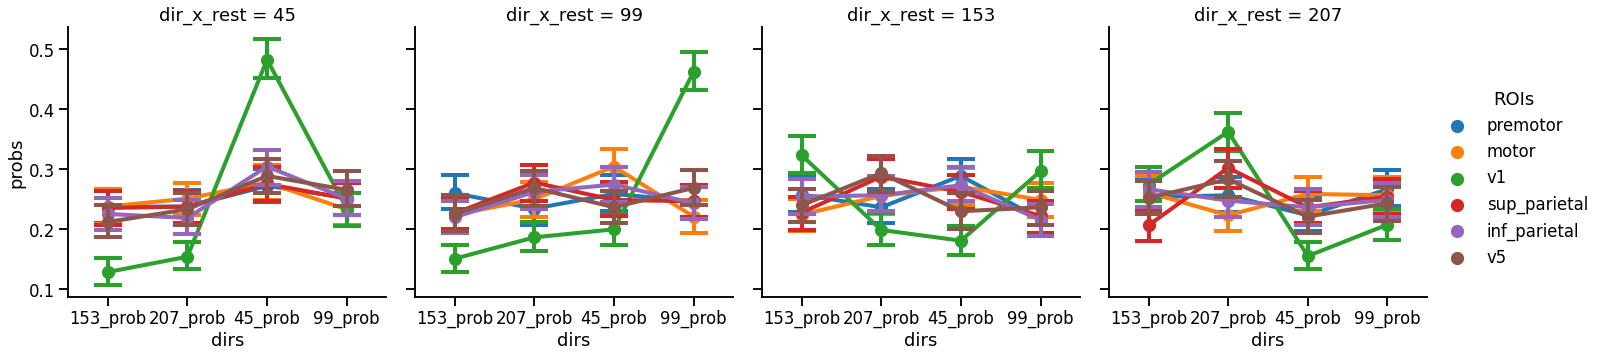

In [73]:

sns.set_context('talk')
ax = sns.catplot(x = 'dirs', y = 'probs', 
            col = 'dir_x_rest', hue = 'ROIs',
            data = between_dec_tree_predictions_df_melt, kind = 'point', capsize = 0.3)
#ax.set_axcd is_labels().set_xticklabels(rotation = 90)


In [254]:
df['run_pairs'] = range(5)

In [255]:
df_melt = df.melt(id_vars="run_pairs", var_name='ROI', value_name='scores')

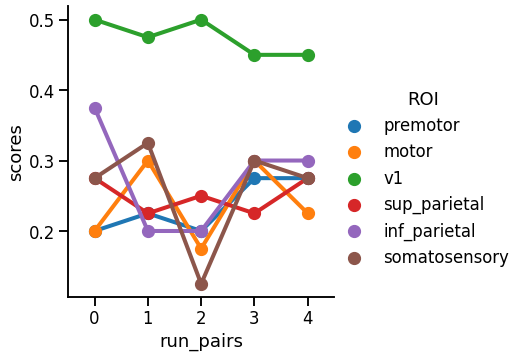

In [346]:
sns.set_context('talk')
sns.catplot(x = 'run_pairs', y = 'scores', hue = 'ROI', data = df_melt, kind = 'point')